In [1]:
## Reminder to Dennis: add last history row to each CCAR scenario for smooth transitions.
## 201704 adapted for 2016 & 2017 CCAR scenarios (updated) ## 
## 201803 adapted for 2018 CCAR scenarios ##

import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
test = '_cboB'  # add sUE2 (scaled) 
cbo = ['Lags','Lags_UE2','Lags_sUE2'] # combo tags (for use in charts)
xvr = [['UE2','sUE2'],['sUE2'],['UE2']]
frsq = [0,0,0] # set up list of full model adj r-sq values

In [3]:
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables
df = pd.read_csv("FailRates_all2.csv") 
adj = pd.read_csv("UE_adj.csv",index_col=0) ## add code to create this file!!!

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])
df['Date'] = pd.to_datetime(df['Date'])
adj['Date'] = pd.to_datetime(adj['Date'])

hs.set_index('Date', drop=True, inplace=True)

## adjust DJ so coeffs are similar scale:
hs['DJ'] = hs['DJ'] / 1000
cc['DJ'] = cc['DJ'] / 1000

## history vars: lag (4q) vars for UE, HPI, CRE:
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']


In [4]:
## select which CCAR years to process: (note: only first 4yrs will be used in final combo charts)

ccyr = [2012,2013,2014,2015,2016,2017,2018] ## all CCAR years (will only show 2012-2015 in ending 4-yr charts)
#ccyr = [2012,2013,2014,2015] ## CCAR years used in book
#ccyr = [2015,2016,2017,2018] ## use this if you want these recent years in final special charts (4 years combined)

In [5]:
ccyb = [ x-2000 for x in ccyr ]  # adjust for base index values
ccyb

[12, 13, 14, 15, 16, 17, 18]

In [6]:
dfpyl2 = [[]]
dfpzl2 = [[]]

for i in np.arange(20):
  dfpyl2.append([])
  dfpzl2.append([])

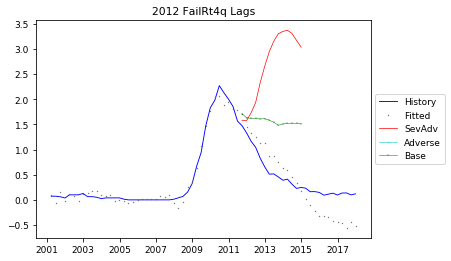

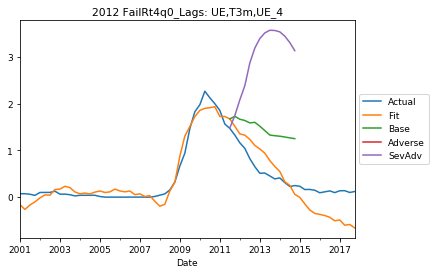

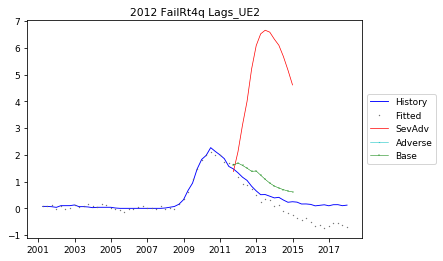

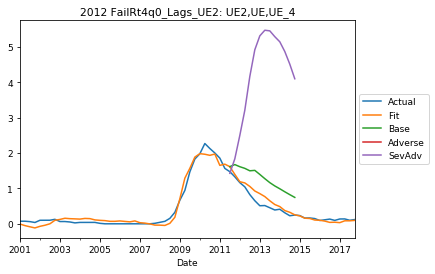

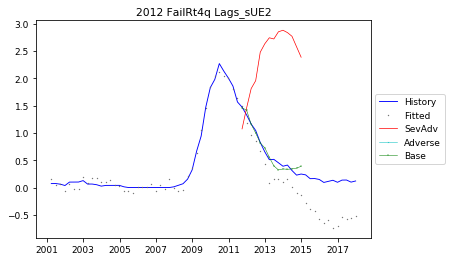

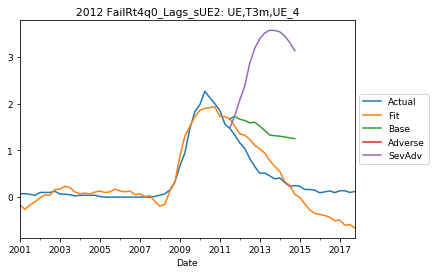

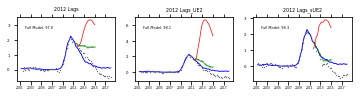

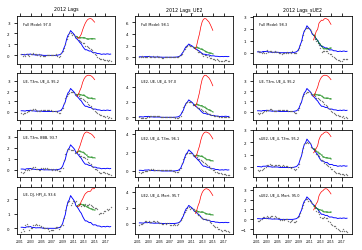

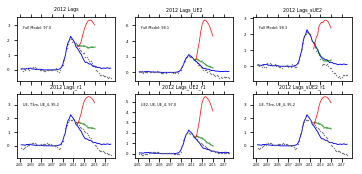

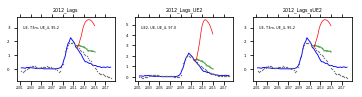

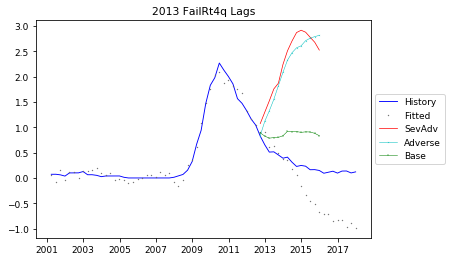

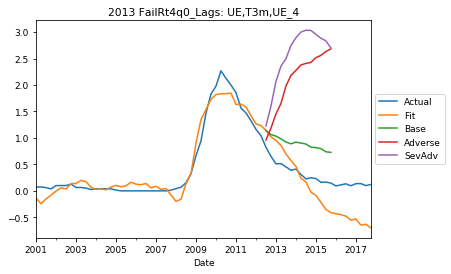

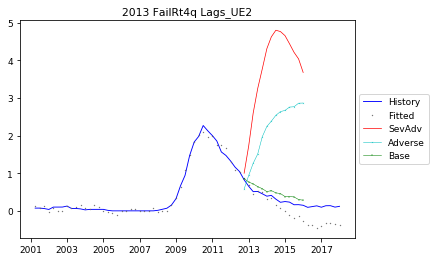

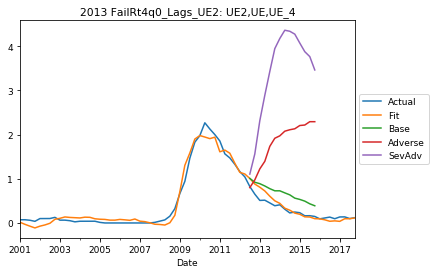

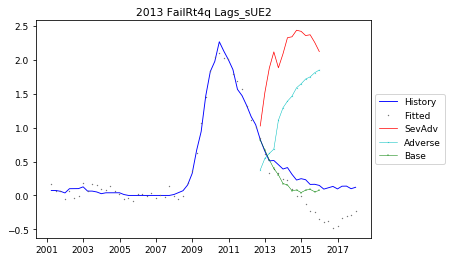

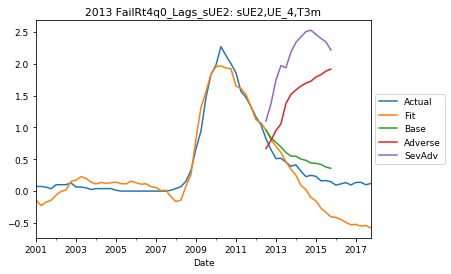

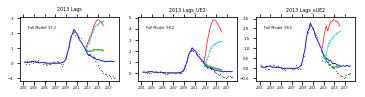

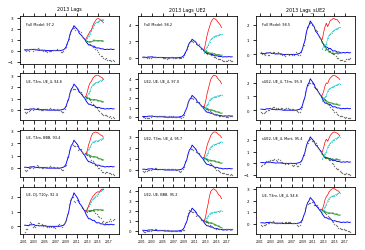

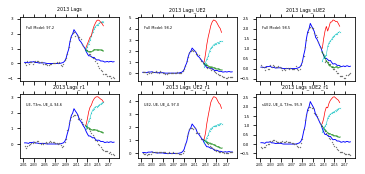

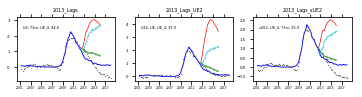

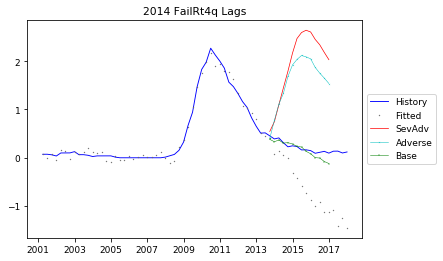

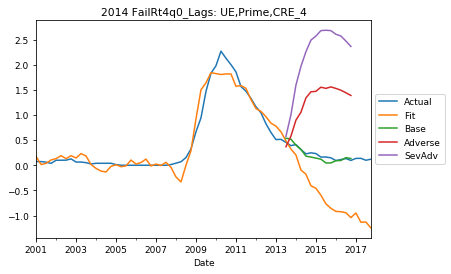

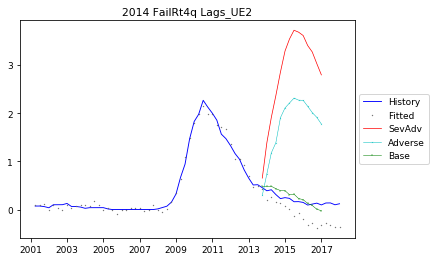

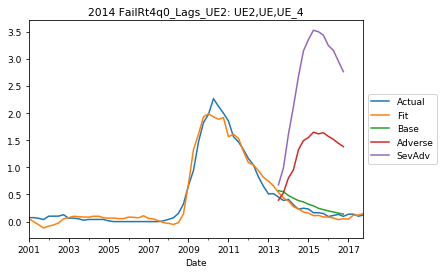

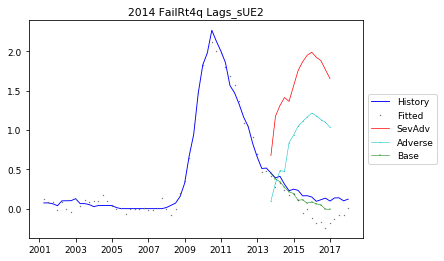

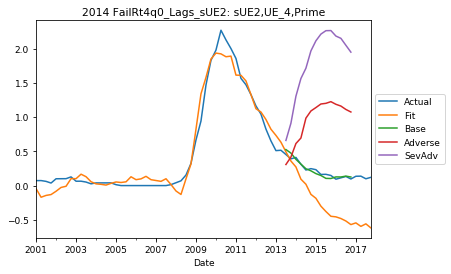

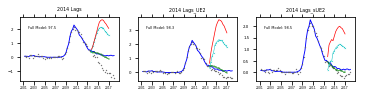

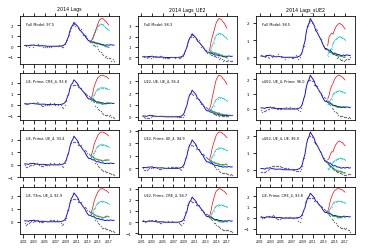

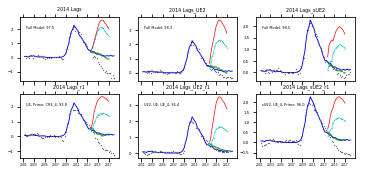

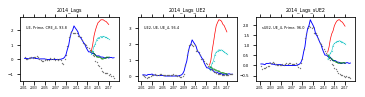

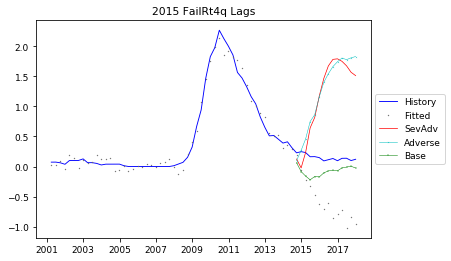

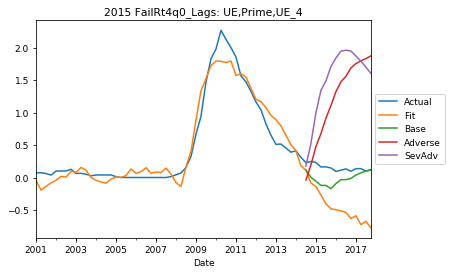

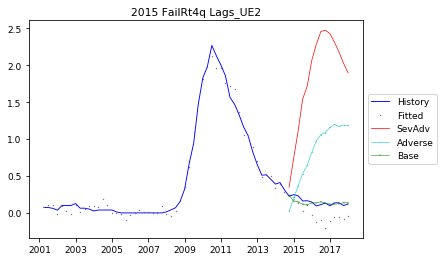

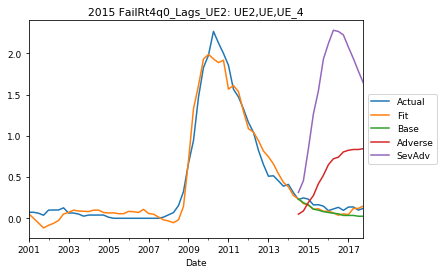

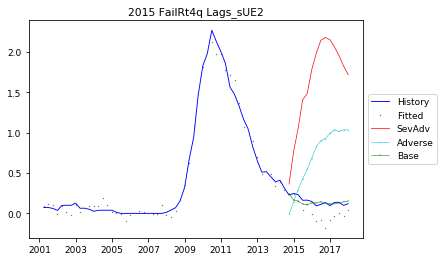

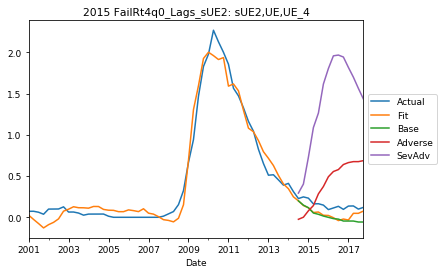

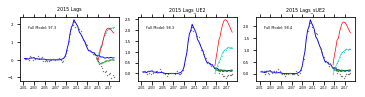

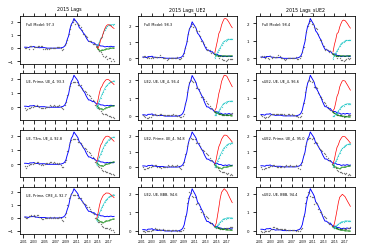

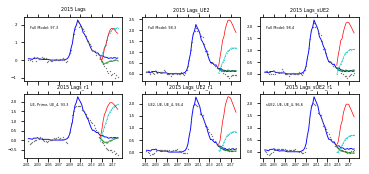

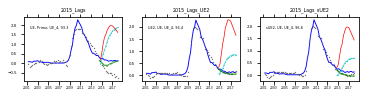

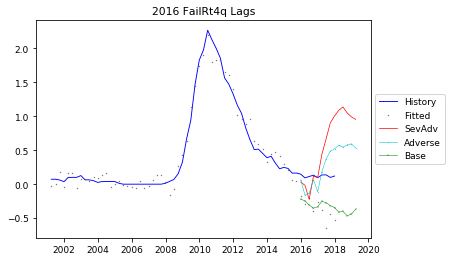

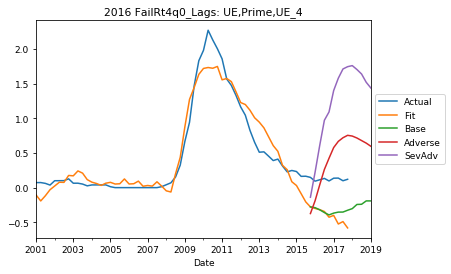

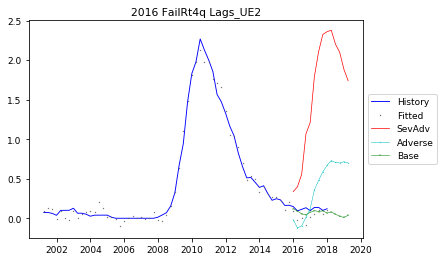

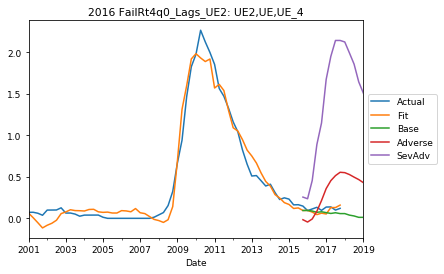

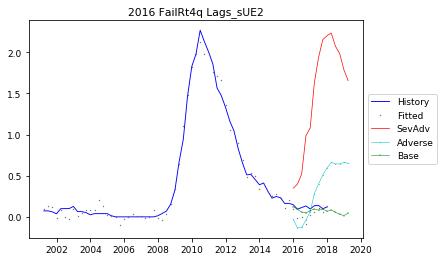

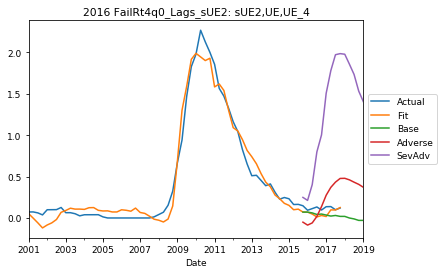

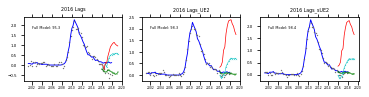

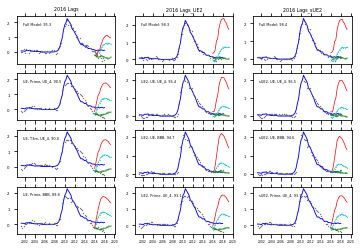

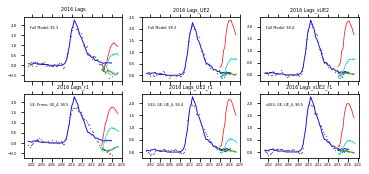

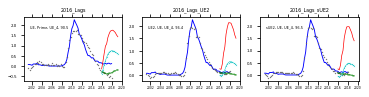

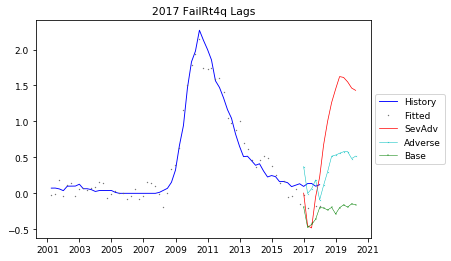

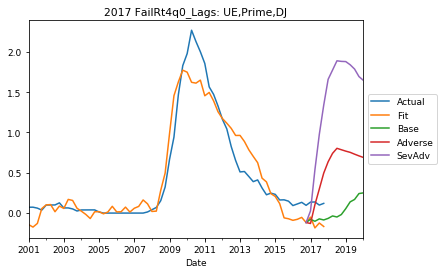

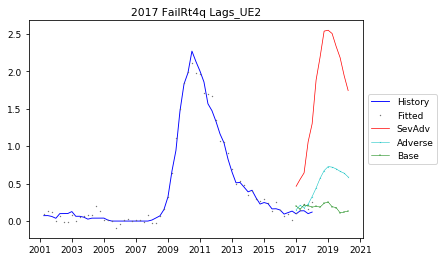

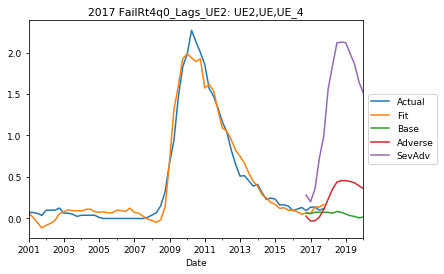

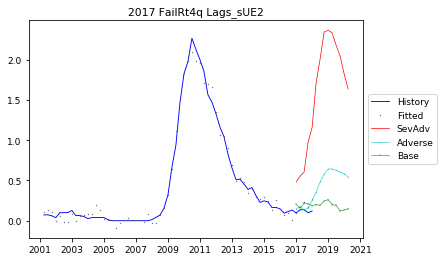

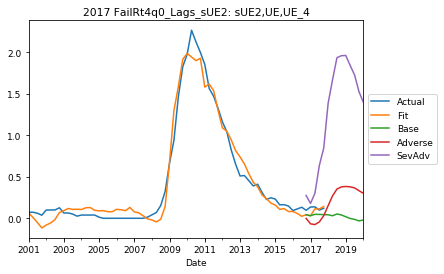

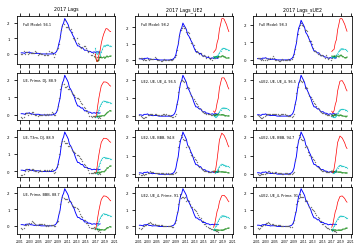

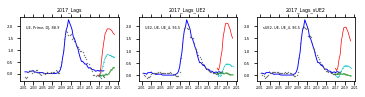

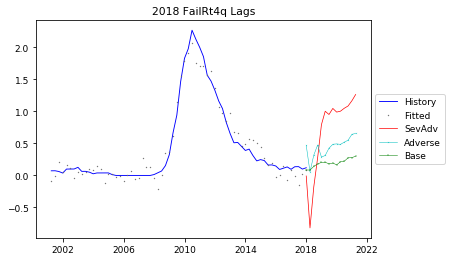

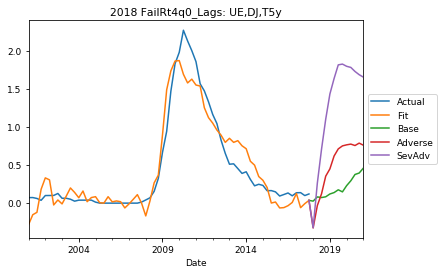

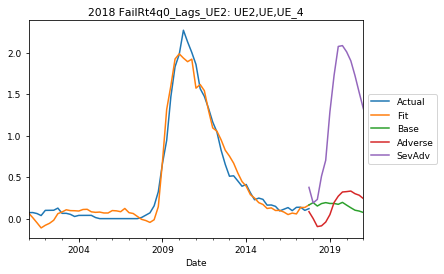

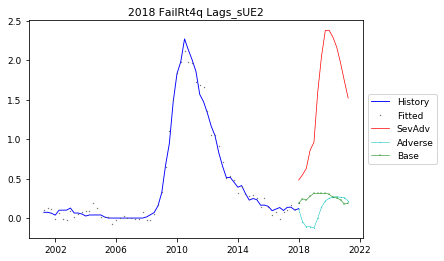

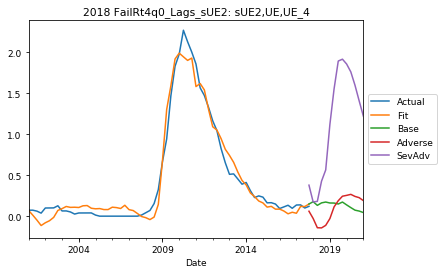

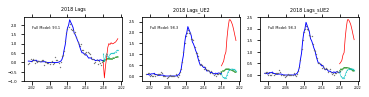

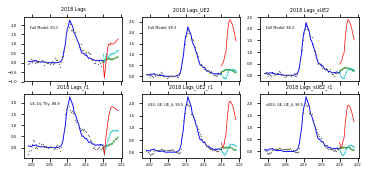

In [7]:
# Process each of the desired CCAR years:
##################################################################################
topn = 3 ## IMPORTANT:  topn defines how many among 3-var models are kept in final tables (pick 3 up to 8)
topx = 2 ## denotes max # of 2-var pairs are allowed in final rankings...(pick 1, 2, or 3)
##################################################################################

grp = 'FailRt'  ## group to analyze within data file

#qtyp = 1 # use 1q charge-off rates (codes in qclst)
qtyp = 4 # use 4q rolling charge-off rates (codes in rclst)

for ccar in ccyr:  ## big loops

  for cbon in [0,1,2]:  ## med loops

    dtst = pd.to_datetime('2001-03-31')  # data start date for all CCAR years
    # new code for 2016 CCAR dates:
    if ccar <= 2015:
      dtend = pd.to_datetime(str(ccar-1) + '-09-30')  # end date for CCAR history & start date for CCAR forecast
      frend = pd.to_datetime(str(ccar+2) + '-12-31')  # end date for CCAR forecast (13-qtr end date)
    else:
      dtend = pd.to_datetime(str(ccar-1) + '-12-31')  # end date for CCAR history & start date for CCAR forecast
      frend = pd.to_datetime(str(ccar+3) + '-03-31')  # end date for CCAR forecast (13-qtr end date)

    # list of standard loan categories to analyze:
    rclst = ['FailRt4q'] 
    qclst = ['FailRt']
    
    if qtyp == 1:
      curlst = qclst
    elif qtyp == 4:
      curlst = rclst
    else:
      curlst = []  # force error if qtyp not 1 or 4
    
    uvr = "adj" + str(ccar-2000)  ## colname for UE adj factors
    
    dfc = df.copy()
    dfc.dropna(axis=0, how='any', inplace=True)
    
    ## set-up files to analyze CCAR test for a specific year (stored in "ccar" variable):  
    ccx = cc[(cc['CCAR'] == ccar)]  # ccx contains forecast periods
    ccx = ccx.dropna(axis=1, how='all').reset_index(drop=True)
    
    ## CCAR vars: create lag (4q) terms for UE, HPI, CRE:
    ccx['UE_4'] = ccx['UE'].shift(4)
    ccx['HPI_4'] = ccx['HPI'].shift(4)
    ccx['CRE_4'] = ccx['CRE'].shift(4)

    for i in np.arange(len(ccx)):
      if np.isnan(ccx.ix[i]['UE_4']):
        yr = ccx.ix[i]['Date'].year - 1
        mn = ccx.ix[i]['Date'].month
        dy = ccx.ix[i]['Date'].day
        dd = str(datetime(yr,mn,dy))[0:10]
        xu = hs.ix[dd[0:7]]['UE'].values
        ccx.loc[i,'UE_4'] = xu
        xh = hs.ix[dd[0:7]]['HPI'].values
        ccx.loc[i,'HPI_4'] = xh
        xc = hs.ix[dd[0:7]]['CRE'].values
        ccx.loc[i,'CRE_4'] = xc


    ## CCAR vars: squared terms for UE and UE_4:
    ccx['UE2'] = ccx['UE'] * ccx['UE']
    
    ccx = ccx.merge(adj[['Date',uvr]],how='left',on='Date')
    ccx[uvr].fillna(1, inplace=True)
    ccx['sUE2'] = ccx['UE2'] * ccx[uvr] * ccx[uvr]
    ccx.drop(uvr, axis=1, inplace=True)
    
    cccol = list(ccx.columns[3:])  # list of all CCAR variables to analyze
    
    suff = cbo[cbon]
    cccol = [k for k in cccol if k not in xvr[cbon]]   ## removes vars listed in xvr list
    
    Xcol = ['Intercept'] + cccol  # model variables using intercept & all CCAR variables
    
    hsf2 = hs.copy()
    hsf = hsf2.reset_index(drop=False)
    
    ## sUE2 variable = UE2*adj*adj:
    hsf = hsf.merge(adj[['Date',uvr]],how='left',on='Date')
    hsf[uvr].fillna(1, inplace=True)
    hsf['sUE2'] = hsf['UE2'] * hsf[uvr] * hsf[uvr]
    hsf.drop(uvr, axis=1, inplace=True)
    hsf = hsf.merge(dfc,how='inner',left_on='Date',right_on='Date') # merge fail rates into history file (hs)
    hsx = hsf[(hsf['Date'] >= dtst) & (hsf['Date'] <= dtend)] # historic periods
    
    ccs = ccx.copy()  # CCAR scenarios for selected year
    if ccar == 2013: cc13 = ccx.copy()
    if ccar == 2015: cc15 = ccx.copy()
    if ccar == 2016: cc16 = ccx.copy()
    if ccar == 2017: cc17 = ccx.copy()
    if ccar == 2018: cc18 = ccx.copy()

    ccs['Intercept'] = 1  # to set up fitting model
    
    hsf['Intercept'] = 1   # to set up fitting for all available history
    hsz = hsf[(hsf['Date'] >= dtst)] # historic periods until current date
    
    # start full model loop here:
    for rc in curlst:
      eqn = rc + " ~ " + " + ".join(cccol)
      yt, Xt = dmatrices(eqn , data=hsx, return_type='dataframe')
      mod = sm.OLS(yt, Xt)
      res_tot = mod.fit()
      pred_tot = res_tot.predict(Xt)
      p_tot = res_tot.predict(ccs[Xcol])  # forecasts
      ccs['pred'] = p_tot
      ## create table holding actual, fitted, and forecasted fail rates
      frt = hsz[['Date', rc]]
      frt['Fit'] = res_tot.predict(hsz[Xcol])
      frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base']
      frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse']
      frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
      frt.set_index('Date', drop=True, inplace=True)
    
      frt2 = frt.copy()
      frt2.columns = [[rc]*len(frt.columns),frt.columns]
    
      prm = res_tot.params
      prm['rsq'] = res_tot.rsquared
      prm['rsq_adj'] = res_tot.rsquared_adj
      prm2 = pd.DataFrame(prm)
      prm2.columns = [rc]
    
      if rc == curlst[0]:
        frt3 = frt2.copy()
        prm3 = prm2.copy()
      else:
        frt3 = frt3.merge(frt2, how='outer', left_index=True, right_index=True)
        prm3 = prm3.merge(prm2, how='outer', left_index=True, right_index=True)
    
    frsq[cbon] = str(round(prm['rsq_adj']*100,1))
    
    frt3.to_csv(grp + "_" + str(ccar) + "_full_fcst_" + str(qtyp) + "q_" + suff + test + ".csv")
    prm3.to_csv(grp + "_" + str(ccar) + "_full_param_" + str(qtyp) + "q_" + suff + test + ".csv")
    
    ## prints out full regression summary for "no transforms" vtyp == 0 only.
    sys.stdout = open(grp + "_" + str(ccar)+"_"+str(qtyp)+"q_"+suff+"_fullsumm"+ test +".txt", "w")
    rsumm = res_tot.summary()
    print(rsumm)
    sys.stdout = sys.__stdout__
    
    if cbon == 0:
      frt3v0 = frt3.copy()  
    elif cbon == 1:
      frt3v1 = frt3.copy()  
    elif cbon == 2:
      frt3v2 = frt3.copy()  
    
    plt.rcParams.update({'font.size': 9})
    xax = list(frt3.index)
    
    for i in [0]:
      plt.plot(xax,frt3[curlst[i],'Actual'],ls='-',c='b',lw=.9,label='History')
      plt.plot(xax,frt3[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='white',ms=1,label='Fitted')
      plt.plot(xax,frt3[curlst[i],'SevAdv'],ls='-',c='r',lw=.7,label='SevAdv')
      plt.plot(xax,frt3[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c',label='Adverse')
      plt.plot(xax,frt3[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2,label='Base')
      plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
      plt.title(str(ccar)+" "+curlst[i]+" "+suff)
    plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full1_'+suff+test+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    ### build 3-var models:
    def df1_topx(group):
      return group.sort_index(by='r1', ascending=False)[:topx]
    
    df1 = pd.DataFrame(columns=['rc','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
    for rc in curlst:
      for v in cccol:
        y, X = dmatrices( rc + ' ~ ' + v , data=hsx, return_type='dataframe')
        mod = sm.OLS(y, X)
        res = mod.fit()
        df1 = df1.append({'rc': rc,'v1': v, 'r1': res.rsquared_adj}, ignore_index=True)
    
    df1g = df1.groupby(['rc'])
    df1t = df1g.apply(df1_topx)
    df1t.index = np.arange(len(df1t))
    
    # stores r-sq values for all 2-var combos:
    df2 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2'])
    st2 = set(frozenset({'rc','x', 'y'}))  # to retain processed var-pairs
    
    for idx, row in df1t.iterrows():
      for v in cccol:
        if (row['v1'] == v) | ({row['rc'], v , row['v1']} in st2):
          pass
        else:
          y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + v , data = hsx, return_type='dataframe')
          mod = sm.OLS(y, X)
          res = mod.fit()
          df2 = df2.append({'rc':row['rc'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.rsquared_adj}, ignore_index=True)
          st2.add(frozenset({row['rc'], v, row['v1']}))
    
    # function to select top 3 for each lead variable:
    def get_topx_2var(group):
      return group.sort_index(by=['r2','r1'], ascending=False)[:topx]
    
    grouped = df2.groupby(['rc','v1'])
    df2a = grouped.apply(get_topx_2var)
    df2a = df2a.sort_index(by=['rc','r2','r1'], ascending=[True,False,False])
    df2a.index = np.arange(len(df2a))
    
    # prep for 3-var combos:
    # stores r-sq values for all 3-var combos:
    df3 = pd.DataFrame(columns=['rc','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
    cf3 = pd.DataFrame(columns=['Int','c1','c2','c3'])
    st3 = set(frozenset({'rc','x', 'y', 'z'}))  # to retain processed var-triples
    
    for idx, row in df2a.iterrows():
      for v in cccol:
        if (row['v1'] == v) | (row['v2'] == v) :
          pass
        elif {row['rc'], v , row['v1'], row['v2']} in st3:
          pass
        else:
          y, X = dmatrices( row['rc'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = hsx, return_type='dataframe')
          mod = sm.OLS(y, X)
          res = mod.fit()
          df3 = df3.append({'rc':row['rc'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],'v3':v,\
                            'r3': res.rsquared_adj},ignore_index=True)
          st3.add(frozenset({row['rc'],v, row['v1'], row['v2']}))
          cm = pd.DataFrame(res.params).T
          cm.columns = ['Int','c1','c2','c3']
          cf3 = cf3.append(cm.ix[0])
    
    cf3 = cf3.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df3 = df3.merge(cf3, how='inner', left_index=True, right_index=True)
    
    # function to select top 3 for each lead variable:
    def get_topx_3var(group):
      return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]
    
    def get_topn_rc(group):
      return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]
    
    df3g = df3.groupby(['rc','v1','v2'])  #  allows 3 for each primary 2-var pair
    df3a = df3g.apply(get_topx_3var)  ## finds best 3 models from each 3-var combo
    df3ag = df3a.groupby(['rc'])  # prep to find 3 best models for each product category
    df3b = df3ag.apply(get_topn_rc)  # find topn models among all 3-var models
    df3b.index = np.arange(len(df3b))
    
    ### sections to generate forecasts for all 3-var models:
    for idx, row in df3b.iterrows():
      rc = row['rc']
      x = idx
      mdx = idx % topn
      eqnc = rc + " ~ " + " + ".join(row[['v1', 'v2', 'v3']])  # regression eqn
      pvar = ["Intercept", row['v1'], row['v2'], row['v3']]  # vars for predictions
      yc, Xc = dmatrices(eqnc , data=hsx, return_type='dataframe')
      modc = sm.OLS(yc, Xc)
      res_c = modc.fit()
      pred_tot = res_c.predict(hsz[pvar])
      p_tot = res_c.predict(ccs[pvar])  # forecasts
      ccs['pred'] = p_tot
      ## create table holding actual, fitted, and forecasted fail rates
      frt = hsz[['Date', rc]]
      frt['Fit'] = res_c.predict(hsz[pvar])
      frt = frt.merge(ccs[ccs['Scen']=='Bas'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base']
      frt = frt.merge(ccs[ccs['Scen']=='Adv'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse']
      frt = frt.merge(ccs[ccs['Scen']=='Sev'][['Date','pred']],how='outer',on='Date')
      frt.columns = ['Date','Actual','Fit','Base','Adverse','SevAdv']
      frt.set_index('Date', drop=True, inplace=True)
    
      frt2 = frt.copy()
    
      frt2.columns = [[rc+str(mdx)]*len(frt.columns),frt.columns] ## sets up level0 column group names
    
      if x == 0:
        frt3b = frt2.copy()
      else:
        frt3b = frt3b.merge(frt2, how='outer', left_index=True, right_index=True)
    
    frt3s = pd.DataFrame(frt3b.ix[str(ccar-1)+'-12-31':str(ccar+1)+'-12-31'].sum())
    frt3s.reset_index(drop=False, inplace=True)
    frt3s.columns = ['rc','scen','amt']
    frpv = pd.pivot_table(frt3s,index='rc',columns='scen',values='amt')
    frpv.reset_index(drop=False, inplace=True)
    frpv['rc2'] = frpv.apply(lambda x: x['rc'][:-1], axis=1)
    dlst = dict(zip(curlst,list(np.arange(len(curlst)))))
    frpv['ord'] = frpv.apply(lambda x: dlst[x['rc2']], axis=1)
    frpv['diff'] = frpv['rc']  # this will rank models by r-sq values
    frpv.sort_index(by=['ord','diff'], ascending=[True,True], inplace=True)  # use for diff=rc only
    frpv.reset_index(drop=True, inplace=True)
    frpv['rk'] = frpv.index % topn + 1
    frpv.sort_index(by=['ord','rc'], ascending=True, inplace=True)
    
    df3bc = df3b.copy()
    df3bc.rename(columns={'rc' : 'rc2'}, inplace=True)
    df3bc['rc'] = df3bc.index % topn
    df3bc['rc'] = df3bc.apply(lambda x: x['rc2']+str(x['rc']), axis=1)
    df3bc = df3bc.merge(frpv[['rc','ord','rk']], on='rc', how='left')
    df3bc.sort_index(by=['ord','rc'], ascending = True, inplace=True)
    df3bc.reset_index(drop=True, inplace=True)
    df3bc.index.names = [grp+str(ccar)+suff]
    
    frt3b.to_csv(grp + "_"  + str(ccar) +'_3v_fcst_' + str(qtyp) + "q_" + suff + test + '.csv')
    df3bc.to_csv(grp + "_"  + str(ccar) + '_3v_param_' + str(qtyp) + "q_" + suff + test + '.csv')
    
    if cbon == 0:
      frt3bv0 = frt3b.copy()  # save results: no lags, no exp
      df3bcv0 = df3bc.copy()  # save params: no lags, no exp
    elif cbon == 1:
      frt3bv1 = frt3b.copy()  # save results: 4q lags, no exp
      df3bcv1 = df3bc.copy() 
    elif cbon == 2:
      frt3bv2 = frt3b.copy()  # save results: 4q lags, exp2
      df3bcv2 = df3bc.copy() 
    
    ver = 0 #   0, 1, 2 only
    frt3b[curlst[0]+str(ver)].plot().legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    plt.title(str(ccar)+" "+curlst[0]+str(ver)+"_"+suff+": "+df3bc.loc[ver,'v1']+","+df3bc.loc[ver,'v2']+","+df3bc.loc[ver,'v3'])
    plt.show()
  
  ###  STOP HERE... run 3 cbon values... then proceed
  ## end of loop for 3 cbon values
  
  ## rename top level of columns from 3 runs for "full" models:
  frt3v0.columns = pd.MultiIndex.from_product([[cbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  frt3v1.columns = pd.MultiIndex.from_product([[cbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  frt3v2.columns = pd.MultiIndex.from_product([[cbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  ## merge the 3 "full" tables into one 
  dfp = frt3v0.merge(frt3v1, how='left', left_index=True, right_index=True)
  dfp = dfp.merge(frt3v2, how='left', left_index=True, right_index=True)
  
  curlst2 = cbo
  dfplst = ['Full Model: ' + e for e in frsq] 
  
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(3):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfp[curlst2[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp[curlst2[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='white',ms=1)
    plt.plot(xax,dfp[curlst2[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp[curlst2[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp[curlst2[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfplst[i], xy=(0.08, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(str(ccar)+" "+curlst2[i])
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom='on') # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q" +'_full'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()

  df3bcv0['rc2'] = cbo[0]
  df3bcv0['ord'] = 0
  df3bcv1['rc2'] = cbo[1]
  df3bcv1['ord'] = 1
  df3bcv2['rc2'] = cbo[2]
  df3bcv2['ord'] = 2
  dfp3 = pd.concat([df3bcv0, df3bcv1, df3bcv2], ignore_index=True)
  dfp3.sort_index(by=['rk','ord'], inplace=True)
  dfp3.reset_index(drop=True, inplace=True)
  
  ## add next 3 sets of results for chart
  dfp2 = dfp.copy()
  dfp2lst = dfplst
  dfpclst = curlst2
  
  rk = 1
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  rk = 1
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  rk = 1
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r1'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r1')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  rk = 2
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2],str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  rk = 2
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  #tmp1.columns = pd.MultiIndex.from_product([['Lags_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  rk = 2
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r2'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r2')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  rk = 3
  ord = 0
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp0 = frt3bv0[rc].copy()
  tmp0.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  rk = 3
  ord = 1
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp1 = frt3bv1[rc].copy()
  tmp1.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  rk = 3
  ord = 2
  rc = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)]['rc']
  tmp2 = frt3bv2[rc].copy()
  tmp2.columns = pd.MultiIndex.from_product([[cbo[ord]+'_r3'], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  vlst = dfp3[(dfp3['ord']== ord) & (dfp3['rk']== rk)][['v1','v2','v3','r3']]
  vlst.reset_index(drop=True, inplace=True)
  vlst2 = [vlst.ix[0,0], vlst.ix[0,1], vlst.ix[0,2], str(round(vlst.ix[0,3]*100,1))]
  dfp2lst.append(', '.join(vlst2))
  dfpclst.append(cbo[ord]+'_r3')
  
  dfp2 = dfp2.merge(tmp0, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp1, how='left', left_index=True, right_index=True)
  dfp2 = dfp2.merge(tmp2, how='left', left_index=True, right_index=True)
  
  curlst = dfpclst
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(12):
    plt.subplot(4, 3, i+1)
    plt.plot(xax,dfp2[curlst[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp2[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfp2[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp2[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp2[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfp2lst[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    if i < 3: plt.title(str(ccar)+" "+curlst[i])
  
    if i < 9:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q"+'_all12'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()

  curlst = dfpclst
  plt.rcParams.update({'font.size': 4})
  
  for i in np.arange(6):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfp2[curlst[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfp2[curlst[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfp2[curlst[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfp2[curlst[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfp2[curlst[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfp2lst[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(str(ccar)+" "+curlst[i])
  
    if i < 3:
      labl = 'off'
    else:
      labl = 'on'
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom=labl) # labels along the bottom edge are off
  
  plt.savefig(grp+'_'+str(ccar) + "_" + str(qtyp) + "q"+'_all6'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()
  
  ## assemble dataframe holding best 3-var models for all ccar years:
  cbor1 = [e + '_r1' for e in cbo]
  dfp_0 = dfp2[cbor1[0]].copy()
  dfp_1 = dfp2[cbor1[1]].copy()
  dfp_2 = dfp2[cbor1[2]].copy()
  ccbo = [str(ccar)+"_" + e for e in cbo]
  dfp_0.columns = pd.MultiIndex.from_product([[ccbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfp_1.columns = pd.MultiIndex.from_product([[ccbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfp_2.columns = pd.MultiIndex.from_product([[ccbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  dfpx = dfp_0.copy()
  dfpx = dfpx.merge(dfp_1, how='left', left_index=True, right_index=True)
  dfpx = dfpx.merge(dfp_2, how='left', left_index=True, right_index=True)
  
  ## NEW CODE:
  dfpyl2[ccar-2000] = dfp2lst[3:6]
  if ccar == ccyr[0]:
    dfpy = dfpx.copy()
  else:
    dfpy = dfpy.merge(dfpx, how='outer', left_index=True, right_index=True)

  
  dfpl = dfp2lst[3:6]
  
  dfpf_0 = dfp2[cbo[0]].copy()
  dfpf_1 = dfp2[cbo[1]].copy()
  dfpf_2 = dfp2[cbo[2]].copy()
  ccbo = [str(ccar)+"_" + e for e in cbo]
  dfpf_0.columns = pd.MultiIndex.from_product([[ccbo[0]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfpf_1.columns = pd.MultiIndex.from_product([[ccbo[1]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  dfpf_2.columns = pd.MultiIndex.from_product([[ccbo[2]], ['Actual','Fit','Base' ,'Adverse', 'SevAdv']])
  
  dfpfx = dfpf_0.copy()
  dfpfx = dfpfx.merge(dfpf_1, how='left', left_index=True, right_index=True)
  dfpfx = dfpfx.merge(dfpf_2, how='left', left_index=True, right_index=True)

  ## NEW CODE:
  dfpzl2[ccar-2000] = dfp2lst[0:3]
  if ccar == ccyr[0]:
    dfpz = dfpfx.copy()
  else:
    dfpz = dfpz.merge(dfpfx, how='outer', left_index=True, right_index=True)


  plt.rcParams.update({'font.size': 4})
  xax = list(dfpx.index)
  
  for i in np.arange(3):
    plt.subplot(3, 3, i+1)
    plt.plot(xax,dfpx[ccbo[i],'Actual'],ls='-',c='b',lw=.9)
    plt.plot(xax,dfpx[ccbo[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
    plt.plot(xax,dfpx[ccbo[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
    plt.plot(xax,dfpx[ccbo[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
    plt.plot(xax,dfpx[ccbo[i],'SevAdv'],ls='-',c='r',lw=.7)
    plt.annotate(dfpl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3.5) # var listing annotation
  
    plt.title(ccbo[i])
  
    plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='major',      # both major and minor ticks are affected
      bottom='on',      # ticks along the bottom edge are off
      top='on',         # ticks along the top edge are off
      pad = 1.5,        # move labels closer to frame
      labelsize = 3,    # decrease font size of year labels
      labelbottom='on') # labels along the bottom edge are off
  plt.savefig(grp+'_' +str(ccar)+"_"+ str(qtyp) + "q" +'_test'+ test +'.png', dpi=400, bbox_inches='tight')
  plt.show()


In [8]:
dfpyl = dfpyl2[ccyr[0]-2000]
dfpzl = dfpzl2[ccyr[0]-2000]
dfpyl, dfpzl

(['UE, T3m, UE_4, 95.2', 'UE2, UE, UE_4, 97.0', 'UE, T3m, UE_4, 95.2'],
 ['Full Model: 97.0', 'Full Model: 98.1', 'Full Model: 98.3'])

In [9]:
for i in np.arange(1,len(ccyr)):
  dfpyl = dfpyl + dfpyl2[ccyr[i]-2000]
  dfpzl = dfpzl + dfpzl2[ccyr[i]-2000]

In [10]:
if len(ccyr) > 4:
  ccyr4 = ccyr[0:4]

In [11]:
## special processing showing up to 4 years in each chart:
## note:  if you want to show 2014, 2015, 2016, 2017; re-run this module using ccyr = [2014, 2015, 2016, 2017]

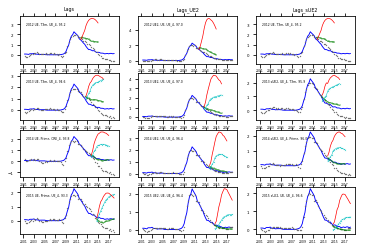

In [12]:
# summary processing of outputs for all CCAR years:

ccby = []

for i in ccyr:
  for j in np.arange(3):
    ccby = ccby + [str(i)+"_"+cbo[j]]

plt.rcParams.update({'font.size': 4})
xay = list(dfpy.index)

for i in np.arange(min(12,len(dfpyl))):
  dyr = str(ccyr[int(i / 3)])
  plt.subplot(4, 3, i+1)
  plt.plot(xay,dfpy[ccby[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xay,dfpy[ccby[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xay,dfpy[ccby[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xay,dfpy[ccby[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xay,dfpy[ccby[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dyr+" "+dfpyl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3) # var listing annotation

  if i < 3: plt.title(cbo[i])
  plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='major',    # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom='on') # labels along the bottom edge are off

plt.savefig(grp+'_'+ str(qtyp) + "q" +'_allyr3var'+ test +'.png', dpi=400, bbox_inches='tight')
plt.show()

######
######

ccbz = []

for i in ccyr:
  for j in np.arange(3):
    ccbz = ccbz + [str(i)+"_"+cbo[j]]

plt.rcParams.update({'font.size': 4})
xaz = list(dfpz.index)

for i in np.arange(min(12,len(dfpzl))):
  dyr = str(ccyr[int(i / 3)])
  plt.subplot(4, 3, i+1)
  plt.plot(xaz,dfpz[ccby[i],'Actual'],ls='-',c='b',lw=.9)
  plt.plot(xaz,dfpz[ccby[i],'Fit'],ls='None', marker='o',c='k',mew=.25,mfc='w',ms=1)
  plt.plot(xaz,dfpz[ccby[i],'Base'],ls='-',lw=.5,marker='+',c='g',mew=.25,ms=1.2)
  plt.plot(xaz,dfpz[ccby[i],'Adverse'],ls='-',lw=.5,marker='x',ms=1.2,mew=.25,c='c')
  plt.plot(xaz,dfpz[ccby[i],'SevAdv'],ls='-',c='r',lw=.7)
  plt.annotate(dyr+" "+dfpzl[i], xy=(0.06, 0.82), xycoords='axes fraction', fontsize=3) # var listing annotation

  if i < 3: plt.title(cbo[i])
  plt.tick_params(
    axis='x',         # changes apply to the x-axis
    which='major',    # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.5,        # move labels closer to frame
    labelsize = 3,    # decrease font size of year labels
    labelbottom='on') # labels along the bottom edge are off

plt.savefig(grp+'_'+ str(qtyp) + "q" +'_allyrfull'+ test +'.png', dpi=400, bbox_inches='tight')
plt.show()

In [13]:
## STOP 
## econ var charts follow